<a href="https://colab.research.google.com/github/gabmachado97/jetson_segmentation/blob/main/IPM_hrnet_w18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Definitions

In [ ]:
!pip install fastai==2.3.0
!pip install -U albumentations
!pip install SemTorch

     |████████████████████████████████| 193 kB 5.4 MB/s 
     |████████████████████████████████| 12.8 MB 25 kB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 776.8 MB 17 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu111
    Uninstalling torchvision-0.10.0+cu111:
      Successfully uninstalled torchvision-0.10.0+cu111
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.7.1 which is incompati

In [ ]:
!pip3 uninstall opencv-python 
!pip3 install opencv-python 

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python-4.1.2.30.dist-info/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/cv2/config-3.7.py
    /usr/local/lib/python3.7/dist-packages/cv2/config.py
    /usr/local/lib/python3.7/dist-packages/cv2/gapi/__init__.py
    /usr/local/lib/python3.7/dist-packages/cv2/load_config_py2.py
    /usr/local/lib/python3.7/dist-packages/cv2/load_config_py3.py
    /usr/local/lib/python3.7/dist-packages/cv2/mat_wrapper/__init__.py
    /usr/local/lib/python3.7/dist-packages/cv2/misc/__init__.py
    /usr/local/lib/python3.7/dist-packages/cv2/misc/version.py
    /usr/local/lib/python3.7/dist-packages/cv2/utils/__init__.py
    /usr/local/lib/python3.7/dist-packages/cv2/version.py
Proceed (y/n)? y
  Successfully uninstalled opencv-python-4.1.2.30
     |██████████████

In [ ]:
import torch
from fastai.vision import *

import cv2
import matplotlib.pyplot as plt
import numpy as np


from pathlib import Path
import fnmatch
import random
import shutil
import numpy as np
from scipy.io import savemat
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from fastai.vision.all import *

import albumentations as A
import cv2

import torch
import torch.onnx

# SemTorch
from semtorch import get_segmentation_learner


#rtk model accuracy
def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


#Load the model

In [ ]:
path = Path('/content/drive/MyDrive/Mestrado/Segmentação/data/HRNet_Data')
path_train_lbl = path/'train_labels_ids' 
path_train_img = path/'train'
path_val_lbl = path/'val_labels_ids' 
path_val_img = path/'val'

#update this path in the next test
path_models = path/'Models/weighted_unet_resnet_34'
path_results = path/'Results/weighted_unet_resnet_34'

codes = np.loadtxt(path/'codes.txt', dtype=str)

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

fnames = get_image_files(path, folders=['train', 'val'])

get_mask = lambda x: PILMask.create((path_train_lbl if x.parent.name == 'train' else path_val_lbl)/f'{x.stem}{x.suffix}')
mask = PILMask.create(get_mask(fnames[1]))
src_size = np.array(mask.shape)

# Baseado no gráfico de distribuição de classes: https://www.mucar3.de/icpr2020-tas500/images/barchart.png
# w ~= [n_pixels_asfalto]/[n_pixels_classe]
class_weights = torch.tensor([
  1.0,
  5.0,
  6.0,
  7.0,
  75.0,
  1000.0,
  3100.0,
  3300.0,
  0.0,
  270.0,
  2200.0,
  1000.0,
  180.0 
]).cuda()

rgb_to_hex = '#%02x%02x%02x'
cmap = [
  "#{0:02x}{1:02x}{2:02x}".format(0,0,0), #background
  "#{0:02x}{1:02x}{2:02x}".format(85,170,127), #roadPaved
  "#{0:02x}{1:02x}{2:02x}".format(255,170,127), ##roadUnpaved
  "#{0:02x}{1:02x}{2:02x}".format(255,255,255), #roadMarking
  "#{0:02x}{1:02x}{2:02x}".format( 255,85,255), #speedBump
  "#{0:02x}{1:02x}{2:02x}".format( 255,255,127), #catsEye
  "#{0:02x}{1:02x}{2:02x}".format(170,0,127), #stormDrain
  "#{0:02x}{1:02x}{2:02x}".format( 0,255,255), #manholeCover
  "#{0:02x}{1:02x}{2:02x}".format(0,0, 27), #patchs
  "#{0:02x}{1:02x}{2:02x}".format(170,0,0), #waterPuddle
  "#{0:02x}{1:02x}{2:02x}".format(255,0,0), #pothole
  "#{0:02x}{1:02x}{2:02x}".format( 255,85,0), #cracks
]
cmap

['#000000',
 '#55aa7f',
 '#ffaa7f',
 '#ffffff',
 '#ff55ff',
 '#ffff7f',
 '#aa007f',
 '#00ffff',
 '#00001b',
 '#aa0000',
 '#ff0000',
 '#ff5500']

In [ ]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0 #Train only
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

class ImageResizer(Transform):
    order=1
    "Resize image to `size` using `resample`"
    def __init__(self, size, resample=Image.BILINEAR):
        if not is_listy(size): size=(size,size)
        self.size,self.resample = (size[1],size[0]),resample

    def encodes(self, o:PILImage): return o.resize(size=self.size, resample=self.resample)
    def encodes(self, o:PILMask):  return o.resize(size=self.size, resample=Image.NEAREST)

augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(0.1, 0.1, p=0.75),
])

tfms = [[PILImage.create], [get_mask, AddMaskCodes(codes)]]
folder_split = FuncSplitter(lambda fname: Path(fname).parent.name == 'val')
src = Datasets(fnames, tfms, splits=folder_split(fnames))

class DiceMulti(Metric):
    "Averaged Dice metric (Macro F1) for multiclass target in segmentation"
    def __init__(self, axis=1): self.axis = axis
    def reset(self): self.inter,self.union,self.total_area = {},{},{}
    def accumulate(self, learn):
        pred,targ = flatten_check(learn.pred.argmax(dim=self.axis), learn.y)
        for c in range(learn.pred.shape[self.axis]):
            p = torch.where(pred == c, 1, 0)
            t = torch.where(targ == c, 1, 0)
            c_inter = (p*t).float().sum().item()
            c_totalSumAreas = (p+t).float().sum().item()
            c_union = c_totalSumAreas-c_inter
            if c in self.inter:
                self.inter[c] += c_inter
                self.total_area[c] += c_totalSumAreas
                self.union[c] += c_union
            else:
                self.inter[c] = c_inter
                self.total_area[c] = c_totalSumAreas
                self.union[c] = c_union
    @property
    def value(self):
        binary_dice_scores = np.array([])
        for c in self.inter:
            binary_dice_scores = np.append(binary_dice_scores, 2.*self.inter[c]/self.total_area[c] if self.total_area[c] > 0 else np.nan)
        return np.nanmean(binary_dice_scores)

class JaccardCoeffMulti(DiceMulti):
  "Implementation of the Averaged Jaccard coefficient that is lighter in RAM -- Mean IoU (Intersection Over Union)"
  @property
  def value(self): 
    binary_jaccard_scores = np.array([])
    for c in self.inter:
        binary_jaccard_scores = np.append(binary_jaccard_scores, self.inter[c]/self.union[c] if self.union[c] > 0 else np.nan)
    return np.nanmean(binary_jaccard_scores)

name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['manholeCover']
def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

iou_metric = JaccardCoeffMulti()

f1_metric = DiceMulti()

metrics = [acc_rtk, iou_metric, f1_metric]

In [ ]:
size = src_size
bs = 1
transforms = [
  ImageResizer((size[0], size[1])), 
  SegmentationAlbumentationsTransform(augmentations), 
  ToTensor(), 
  IntToFloatTensor()
]

def hrnet_splitter(model):
    return [params(model.backbone), params(model.head)]

data = src.dataloaders(bs=bs, after_item=transforms)

# data.show_batch(max_n=6)

def get_learner(load_modelo=None, weights=None):

  #Feito inicialmente com definições fixas para teste
  learn = get_segmentation_learner(dls=data, number_classes=13, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w18", 
                                 metrics=metrics, wd=1e-2,
                                 splitter=hrnet_splitter, pretrained=True,
                                 loss_func=CrossEntropyLossFlat(axis=1, weight=weights)).to_fp16()

  learn.path = path_models
  if(load_modelo != None):
    learn = learn.load(load_modelo,with_opt=False)
    #learn.summary
    #learn = get_segmentation_learner(dls=data, number_classes=13, segmentation_type="Semantic Segmentation",
    #                             architecture_name="hrnet", backbone_name="hrnet_w18", 
    #                             metrics=metrics, wd=1e-2, cbs=callb,
    #                             splitter=hrnet_splitter, pretrained=True,
    #                             loss_func=CrossEntropyLossFlat(axis=1, weight=class_weights)).to_fp16()

  return learn

In [ ]:
#new_dl = data.test_dl(data.valid_ds.items[:1000], with_labels=True)
data.loaders.append(data.test_dl(data.valid_ds.items[:50], with_labels=True))
learn = get_learner('stg2')

100%|██████████| 83749/83749 [00:02<00:00, 33994.52KB/s]


# Calibration IPM

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
esq_sup = (90,140)
dir_sup = (262,140)
esq_inf = (10,258)
dir_inf = (342,258)

esq_sup = (220,140)
dir_sup = (262,140)
esq_inf = (105,258)
dir_inf = (342,258)

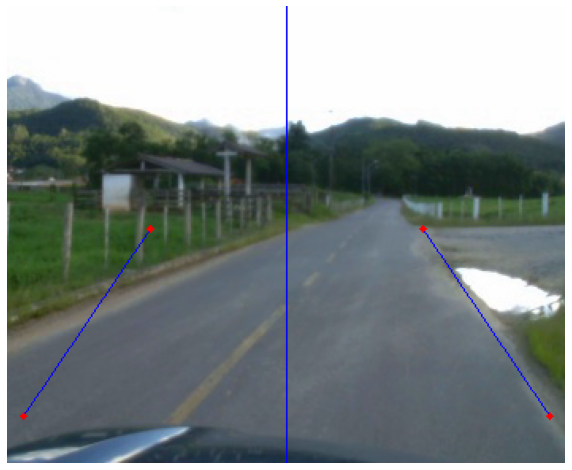

In [ ]:
pframe = '/content/drive/MyDrive/Mestrado/Segmentação/IPM/input/000000001.png'

frame = cv2.imread(pframe)
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#frame = saved_frame.copy()
#288x352
esq_sup = (90,140)
dir_sup = (262,140)
esq_inf = (10,258)
dir_inf = (342,258)

frame = cv2.line(frame, esq_sup,
                      esq_inf,
                      (255,0,0), 1)
frame = cv2.line(frame, dir_sup,
                     dir_inf,
                      (255,0,0), 1)

frame = cv2.circle(frame, esq_sup, 2, (0, 0, 255), -1) #ESQUERDA SUPERIOR
frame = cv2.circle(frame, dir_sup, 2, (0, 0, 255), -1) #DIREITA SUPERIOR
frame = cv2.circle(frame, esq_inf, 2, (0, 0, 255), -1) #ESQUERDA INFERIOR
frame = cv2.circle(frame, dir_inf, 2, (0, 0, 255), -1) #DIREITA INFERIOR

frame = cv2.line(frame, (352//2,0),
                      (352//2,288),
                      (255,0,0), 1)



frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (10,10))
plt.imshow(frame), plt.axis("off")
plt.show()

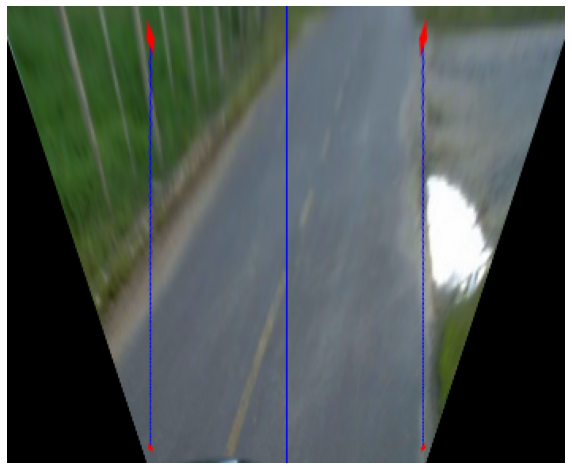

In [ ]:
#desired backup coordinates
esq_sup_out = (90,20)
dir_sup_out = (262,20)
esq_inf_out = (90,278)
dir_inf_out = (262,278)

# Vertices coordinates in the source image
source_points = np.array([[esq_sup[0], esq_sup[1]],
              [dir_sup[0], dir_sup[1]],
              [esq_inf[0], esq_inf[1]],
              [dir_inf[0], dir_inf[1]]], dtype=np.float32)

# Vertices coordinates in the destination image
target_points = np.array([[esq_sup_out[0], esq_sup_out[1]],
              [dir_sup_out[0], dir_sup_out[1]],
              [esq_inf_out[0], esq_inf_out[1]],
              [dir_inf_out[0], dir_inf_out[1]]], dtype=np.float32)

matrix = cv2.getPerspectiveTransform(source_points, target_points)

result = cv2.warpPerspective(frame, matrix, (352, 288), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT,
                                 borderValue=0)

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (10,10))
plt.imshow(result), plt.axis("off")
plt.show()

In [ ]:
matrix


array([[-9.64638783e+00, -1.33840304e+01,  1.87376426e+03],
       [ 1.32967062e-14, -4.22319392e+01,  5.71954373e+03],
       [ 3.48437770e-17, -7.60456274e-02,  1.00000000e+00]])

# Video IPM with original input

In [ ]:
video_input = '/content/drive/MyDrive/Mestrado/Segmentação/IPM/input/rtk_video.mp4'
video_output ='/content/drive/MyDrive/Mestrado/Segmentação/IPM/output/rtk_video.mp4'

width = 352
height = 288
cap = cv2.VideoCapture(video_input)
out = cv2.VideoWriter(video_output,cv2.VideoWriter_fourcc(*'MP4V'),20.0, (width,height))

if (cap.isOpened()== False):
  print("Error opening video stream or file")
 
while (cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()


  if ret == True: 
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # convert from PIL to CV2

    #matrix = cv2.getPerspectiveTransform(source_points, target_points)

    frame = cv2.warpPerspective(frame, matrix, (352, 288), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT,
                                 borderValue=0)

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #write a video
    out.write(frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
      break
  else:
    break


# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

#Inference

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice


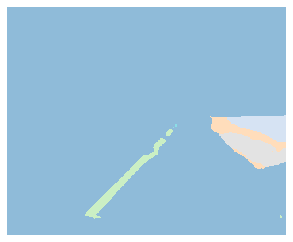

In [ ]:
prediction = learn.predict(pframe)
prediction[0].show(figsize=(5,5))

In [ ]:
%load_ext cython

In [ ]:
%%cython -a
import cython
cimport numpy
import cv2 as cv
import numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
#def colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
cpdef numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
  # set the variable extension types
  cdef int x, y, width, height, b, g, r

  #frame = cv.imdecode(np.frombuffer(byteframe, np.uint8), -1)

  # grab the image dimensions
  width = 288
  height = 352
    
  # loop over the image, pixel by pixel
  for x in range(width):
    for y in range(height):
      b, g, r = frame[x, y]
      if (b, g, r) == (0,0,0): #background
        frame[x, y] = (0,0,0)
      elif (b, g, r) == (1,1,1): #roadAsphalt
        frame[x, y] = (85,85,255)
      elif (b, g, r) == (2,2,2): #roadPaved
        frame[x, y] = (85,170,127)
      elif (b, g, r) == (3,3,3): #roadUnpaved
        frame[x, y] = (255,170,127) 
      elif (b, g, r) == (4,4,4): #roadMarking
        frame[x, y] = (255,255,255) 
      elif (b, g, r) == (5,5,5): #speedBump
        frame[x, y] = (255,85,255)
      elif (b, g, r) == (6,6,6): #catsEye
        frame[x, y] = (255,255,127)          
      elif (b, g, r) == (7,7,7): #stormDrain
        frame[x, y] = (170,0,127) 
      elif (b, g, r) == (8,8,8): #manholeCover
        frame[x, y] = (0,255,255) 
      elif (b, g, r) == (9,9,9): #patchs
        frame[x, y] = (0,0,127) 
      elif (b, g, r) == (10,10,10): #waterPuddle
        frame[x, y] = (170,0,0)
      elif (b, g, r) == (11,11,11): #pothole
        frame[x, y] = (255,0,0)
      elif (b, g, r) == (12,12,12): #cracks
        frame[x, y] = (255,85,0)
 
  frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
  
  # return the colored image
  return frame

In [ ]:
%%cython -a
import cython
cimport numpy
import cv2 as cv
import numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
#def colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
cpdef numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] colorgray_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
  # set the variable extension types
  cdef int x, y, width, height, b, g, r

  #frame = cv.imdecode(np.frombuffer(byteframe, np.uint8), -1)

  # grab the image dimensions
  width = 288
  height = 352
    
  # loop over the image, pixel by pixel
  for x in range(width):
    for y in range(height):
      b, g, r = frame[x, y]
      if (b, g, r) == (0,0,0): #background
        frame[x, y] =(0,0,0)
      elif (b, g, r) == (1,1,1): #roadAsphalt
        frame[x, y] = (255,255,255)
      elif (b, g, r) == (2,2,2): #roadPaved
        frame[x, y] = (255,255,255)
      elif (b, g, r) == (3,3,3): #roadUnpaved
        frame[x, y] = (255,255,255)
      elif (b, g, r) == (4,4,4): #roadMarking
        frame[x, y] = (255,255,255) 
      elif (b, g, r) == (5,5,5): #speedBump
        frame[x, y] = (255,255,255)
      elif (b, g, r) == (6,6,6): #catsEye
        frame[x, y] = (255,255,255)       
      elif (b, g, r) == (7,7,7): #stormDrain
        frame[x, y] = (255,255,255) 
      elif (b, g, r) == (8,8,8): #manholeCover
        frame[x, y] = (0,255,255) 
      elif (b, g, r) == (9,9,9): #patchs
        frame[x, y] = (255,255,255) 
      elif (b, g, r) == (10,10,10): #waterPuddle
        frame[x, y] = (255,255,255) 
      elif (b, g, r) == (11,11,11): #pothole
        frame[x, y] = (255,255,255) 
      elif (b, g, r) == (12,12,12): #cracks
        frame[x, y] = (255,255,255) 
 
  frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
  
  # return the colored image
  return frame

#Create Mask IPM

In [ ]:
video_input = '/content/drive/MyDrive/Mestrado/Segmentação/IPM/input/rtk_video.mp4'
video_output ='/content/drive/MyDrive/Mestrado/Segmentação/IPM/output/mask_rtk.mp4'

width = 352
height = 288
cap = cv2.VideoCapture(video_input)
#out = cv2.VideoWriter(video_output,cv2.VideoWriter_fourcc(*'MP4V'),20.0, (width,height))

if (cap.isOpened()== False):
  print("Error opening video stream or file")
fqtd = 0
while (cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()


  if ret == True: 
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # convert from PIL to CV2

    #matrix = cv2.getPerspectiveTransform(source_points, target_points)

    #frame = cv2.warpPerspective(frame, matrix, (352, 288), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT,
    #                             borderValue=0)
    #prediction = learn.predict(pframe)
    mask = learn.predict(PILImage.create(frame))[0]
    arr = np.array(mask).astype(np.uint8)
    name = "%09d.png"%fqtd
    cv2.imwrite('/content/drive/MyDrive/Mestrado/Segmentação/IPM/output/mask/'+name, arr)
    
    #arr[arr == len(codes) - 1] = 255
    #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #write a video
    #out.write(arr)
    fqtd += 1
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break
  else:
    break


# Release everything if job is finished
cap.release()
#out.release()
cv2.destroyAllWindows()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice


#Color Video Mask IPM

In [ ]:
import timeit
# Count variables
fqtd = 0
video_output ='/content/drive/MyDrive/Mestrado/Segmentação/IPM/output/colored/mask_rtk_colored_IPM.mp4'
filenames = [img for img in glob.glob("/content/drive/MyDrive/Mestrado/Segmentação/IPM/output/mask/*.png")]
out = cv2.VideoWriter(video_output,cv2.VideoWriter_fourcc(*'MP4V'),20.0, (352,288))

filenames.sort() # ADD THIS LINE

for img in filenames:
  frame = cv2.imread(img)

  #%timeit colorfull_fast(frame)
  
  frame = colorfull_fast(frame)
  name = "%09d.png"%fqtd
  frame = cv2.warpPerspective(frame, matrix, (352, 288), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT,
                                 borderValue=0)
  #cv.imwrite(os.path.join(path_crst, name), frame)
  out.write(frame)
  fqtd += 1
  #print(fqtd)
out.release()
cv2.destroyAllWindows()
print("Done!")

Done!


# Convert Mask to Binary (Road - Not Road)

In [ ]:
np.set_printoptions(threshold=np.inf)

In [ ]:
import timeit
from skimage.morphology import skeletonize
from skimage import img_as_bool, color
from skimage.util import invert
from skimage.filters import threshold_otsu

# Count variables
fqtd = 0
video_output ='/content/drive/MyDrive/Mestrado/Segmentação/IPM/output/colored/mask_rtk_binary_IPM_w_contour_and_skeleton.mp4'
filenames = [img for img in glob.glob("/content/drive/MyDrive/Mestrado/Segmentação/IPM/output/mask/*.png")]
out = cv2.VideoWriter(video_output,cv2.VideoWriter_fourcc(*'MP4V'),20.0, (352,288))

filenames.sort() # ADD THIS LINE

for img in filenames:
  frame = cv2.imread(img)

  #%timeit colorfull_fast(frame)
  
  frame = colorgray_fast(frame)
  name = "%09d.png"%fqtd
  frame = cv2.warpPerspective(frame, matrix, (352, 288), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT,
                                 borderValue=0)
  
  
  gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

  # Step 1: Create an empty skeleton
  size = np.size(gray)
  skel = np.zeros(gray.shape, np.uint8)

  # Get a Cross Shaped Kernel
  element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

# Repeat steps 2-4
  while True:
    #Step 2: Open the image
    open = cv2.morphologyEx(gray, cv2.MORPH_OPEN, element)
    #Step 3: Substract open from the original image
    temp = cv2.subtract(gray, open)
    #Step 4: Erode the original image and refine the skeleton
    eroded = cv2.erode(gray, element)
    skel = cv2.bitwise_or(skel,temp)
    img = eroded.copy()
    # Step 5: If there are no white pixels left ie.. the image has been completely eroded, quit the loop
    if cv2.countNonZero(img)==0:
      break
  out.write(skel)
  fqtd += 1
  print(fqtd)
out.release()
cv2.destroyAllWindows()
print("Done!")

In [ ]:
import timeit
from skimage.morphology import skeletonize
from skimage import img_as_bool, color
from skimage.util import invert
from skimage.filters import threshold_otsu
from skimage.morphology import medial_axis

# Count variables
fqtd = 0
video_output ='/content/drive/MyDrive/Mestrado/Segmentação/IPM/output/colored/mask_rtk_binary_IPM_w_contour_and_skeleton.mp4'
filenames = [img for img in glob.glob("/content/drive/MyDrive/Mestrado/Segmentação/IPM/output/mask/*.png")]
out = cv2.VideoWriter(video_output,cv2.VideoWriter_fourcc(*'MP4V'),20.0, (352,288))

filenames.sort() # ADD THIS LINE

for img in filenames:
  frame = cv2.imread(img)

  #%timeit colorfull_fast(frame)
  
  frame = colorgray_fast(frame)
  name = "%09d.png"%fqtd
  frame = cv2.warpPerspective(frame, matrix, (352, 288), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT,
                                 borderValue=0)
  
  
  gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)



# Load your trimmed image as greyscale
  #image = cv2.imread("a.png", cv2.IMREAD_GRAYSCALE)

# Find medial axis
  skel = medial_axis(gray).astype(np.uint8)
  # Save
  cv2.imwrite("/content/drive/MyDrive/Mestrado/Segmentação/IPM/output/skeleton/"+name, skel*255)
  #out.write(skel)
  fqtd += 1
  print(fqtd)
out.release()
cv2.destroyAllWindows()
print("Done!")

In [ ]:
import timeit
from skimage.morphology import skeletonize
from skimage import img_as_bool, color
from skimage.util import invert
from skimage.filters import threshold_otsu
from skimage.morphology import medial_axis

# Count variables
fqtd = 0
video_output ='/content/drive/MyDrive/Mestrado/Segmentação/IPM/output/colored/mask_rtk_binary_IPM_w_contour_and_skeleton2.mp4'
filenames = [img for img in glob.glob("/content/drive/MyDrive/Mestrado/Segmentação/IPM/output/skeleton/*.png")]
out = cv2.VideoWriter(video_output,cv2.VideoWriter_fourcc(*'MP4V'),20.0, (352,288))

filenames.sort() # ADD THIS LINE

for img in filenames:
  frame = cv2.imread(img)
  out.write(frame)
  fqtd += 1
  print(fqtd)
out.release()
cv2.destroyAllWindows()
print("Done!")

# Group 2 videos

In [ ]:
from moviepy.editor import VideoFileClip, concatenate_videoclips


from moviepy.editor import VideoFileClip, clips_array, vfx

clip1 = VideoFileClip("/content/drive/MyDrive/Mestrado/Segmentação/IPM/input/rtk_video.mp4").margin(10) # add 10px contour
clip2 = VideoFileClip("/content/drive/MyDrive/Mestrado/Segmentação/IPM/output/rtk_video.mp4") # add 10px contour
clip3 = VideoFileClip("/content/drive/MyDrive/Mestrado/Segmentação/IPM/output/colored/mask_rtk_colored_IPM.mp4")
clip4 = VideoFileClip("/content/drive/MyDrive/Mestrado/Segmentação/IPM/output/colored/mask_rtk_binary_IPM_w_contour_v2.mp4")
clip5 = VideoFileClip("/content/drive/MyDrive/Mestrado/Segmentação/IPM/output/colored/mask_rtk_binary_IPM_w_contour_v2.mp4")
clip4 = VideoFileClip("/content/drive/MyDrive/Mestrado/Segmentação/IPM/output/colored/mask_rtk_binary_IPM_w_contour_v2.mp4")

final_clip = clips_array([[clip1, clip2],
                          [clip3, clip4],
                          [clip5, clip5]])
final_clip.resize(width=388*2).write_videofile("/content/drive/MyDrive/Mestrado/Segmentação/IPM/output/scenes_test.mp4")

[MoviePy] >>>> Building video /content/drive/MyDrive/Mestrado/Segmentação/IPM/output/scenes_test.mp4
[MoviePy] Writing video /content/drive/MyDrive/Mestrado/Segmentação/IPM/output/scenes_test.mp4


100%|██████████| 1636/1636 [02:05<00:00, 13.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Mestrado/Segmentação/IPM/output/scenes_test.mp4 

